In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image_rgb(img):
    """
    Preprocess the input RGB image to enhance edges by applying edge detection on each channel.
    
    Parameters:
    img (np.ndarray): The input RGB image as a NumPy array.
    
    Returns:
    np.ndarray: Combined edge-detected image from all channels.
    """
    channels = cv2.split(img)
    edges = []
    
    for channel in channels:
        blurred_channel = cv2.GaussianBlur(channel, (5, 5), 0)
        adaptive_thresh = cv2.adaptiveThreshold(
            blurred_channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
        
        kernel = np.ones((3, 3), np.uint8)
        morph_channel = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
        morph_channel = cv2.morphologyEx(morph_channel, cv2.MORPH_OPEN, kernel, iterations=2)
        
        channel_edges = cv2.Canny(morph_channel, 30, 100)
        edges.append(channel_edges)
    
    combined_edges = cv2.bitwise_or(edges[0], edges[1])
    combined_edges = cv2.bitwise_or(combined_edges, edges[2])
    
    return combined_edges

def find_initial_edges_rgb(img, interval, step, gap):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint8:
        raise ValueError("Image must be a NumPy array of type uint8")
    if interval <= 0 or not isinstance(interval, int):
        raise ValueError("Interval must be a positive integer")

    edges = preprocess_image_rgb(img)

    image_height, image_width = img.shape[:2]
    col_indices = np.arange(0, image_width, interval)
    
    up_start, low_start = int(image_height / 4), int(image_height * 3 / 4)
    upper_edge_rvals = np.full(len(col_indices), up_start, dtype=np.uint16)
    lower_edge_rvals = np.full(len(col_indices), low_start, dtype=np.uint16)
    upper_edge_found = np.zeros(len(col_indices), dtype=bool)
    lower_edge_found = np.zeros(len(col_indices), dtype=bool)

    for i, c in enumerate(col_indices):
        col = edges[:, c]
        col = col[up_start:low_start+1]
        
        upper_r, lower_r = up_start, low_start

        for r in range(up_start, low_start):
            if col[r - up_start] == 255:
                upper_edge_rvals[i] = r
                upper_edge_found[i] = True
                break

        for r in range(low_start, up_start, -1):
            if col[r - up_start] == 255:
                lower_edge_rvals[i] = r
                lower_edge_found[i] = True
                break
        
    return upper_edge_rvals, lower_edge_rvals, upper_edge_found, lower_edge_found

def simulated_annealing(col_indices, upper_edge_rvals, lower_edge_rvals, up_start, low_start, upper_edge_found, lower_edge_found, iterations, initial_temp, cooling_rate, step):
    temp = initial_temp
    for _ in range(iterations):
        for i in range(1, len(col_indices) - 1):
            if not upper_edge_found[i]:
                current_upper_r = upper_edge_rvals[i]
                new_upper_r = current_upper_r + np.random.randint(-step, step)
                new_upper_r = np.clip(new_upper_r, up_start, low_start)
                if new_upper_r < lower_edge_rvals[i] - 10:
                    current_cost = np.abs(current_upper_r - np.mean([upper_edge_rvals[i-1], upper_edge_rvals[i+1]]))
                    new_cost = np.abs(new_upper_r - np.mean([upper_edge_rvals[i-1], upper_edge_rvals[i+1]]))
                    if new_cost < current_cost or np.exp((current_cost - new_cost) / temp) > np.random.rand():
                        upper_edge_rvals[i] = new_upper_r

            if not lower_edge_found[i]:
                current_lower_r = lower_edge_rvals[i]
                new_lower_r = current_lower_r + np.random.randint(-step, step)
                new_lower_r = np.clip(new_lower_r, up_start, low_start)
                if new_lower_r > upper_edge_rvals[i] + 10:
                    current_cost = np.abs(current_lower_r - np.mean([lower_edge_rvals[i-1], lower_edge_rvals[i+1]]))
                    new_cost = np.abs(new_lower_r - np.mean([lower_edge_rvals[i-1], lower_edge_rvals[i+1]]))
                    if new_cost < current_cost or np.exp((current_cost - new_cost) / temp) > np.random.rand():
                        lower_edge_rvals[i] = new_lower_r

        temp *= cooling_rate

    return upper_edge_rvals, lower_edge_rvals

def local_smoothing(arr, window_size=5):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='same')

def process_single_image(np_img, channels, intvl, step, gap, iterations=1000, initial_temp=1.0, cooling_rate=0.99):
    interval = intvl

    if channels == 1:
        raise NotImplementedError("Simulated annealing is currently implemented for RGB images only.")
    else:
        col_indices = np.arange(0, np_img.shape[1], interval)
        upper_edge_row_vals, lower_edge_row_vals, upper_edge_found, lower_edge_found = find_initial_edges_rgb(np_img, interval, step, gap)
        up_start, low_start = int(np_img.shape[0] / 4), int(np_img.shape[0] * 3 / 4)

        initial_upper_edge_row_vals = upper_edge_row_vals.copy()
        initial_lower_edge_row_vals = lower_edge_row_vals.copy()

        upper_edge_row_vals, lower_edge_row_vals = simulated_annealing(
            col_indices, upper_edge_row_vals, lower_edge_row_vals, up_start, low_start, upper_edge_found, lower_edge_found, iterations, initial_temp, cooling_rate, step
        )
        
        upper_edge_row_vals[upper_edge_found] = initial_upper_edge_row_vals[upper_edge_found]
        lower_edge_row_vals[lower_edge_found] = initial_lower_edge_row_vals[lower_edge_found]
    
    return upper_edge_row_vals[:28], lower_edge_row_vals[:28]  # Ensure only 28 points are returned for each edge

def process_all_images(input_folder, channels, intvl, step, gap, iterations=1000, initial_temp=1.0, cooling_rate=0.99):
    results = []
    for label in range(5):
        label_folder = os.path.join(input_folder, str(label))
        if os.path.exists(label_folder):
            for img_name in os.listdir(label_folder):
                img_path = os.path.join(label_folder, img_name)
                try:
                    original_img = Image.open(img_path)
                    np_img = np.array(original_img)
                    upper_edge_row_vals, lower_edge_row_vals = process_single_image(np_img, channels, intvl, step, gap, iterations, initial_temp, cooling_rate)

                    # Combine upper and lower edge row values into a single array
                    edge_row_vals = np.concatenate((upper_edge_row_vals, lower_edge_row_vals))

                    # Prepare the row data with Grade, ImageID, and 56 values
                    row_data = [label, img_name] + edge_row_vals.tolist()
                    results.append(row_data)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    
    return results

# Main Program
input_folder = '/kaggle/input/fast-segmented-knee-xray-dataset/fastsam_knee_xray_dataset/train'
results = process_all_images(input_folder, 3, 4, 4, 20)

# Example of saving results to a CSV file
columns = ['Grade', 'ImageID'] + [f'Point_{i+1}' for i in range(56)]
df = pd.DataFrame(results, columns=columns)
df.to_csv('joint_space_measurements.csv', index=False)

print("Processing complete. Results saved to 'joint_space_measurements.csv'.")


Processing complete. Results saved to 'joint_space_measurements.csv'.


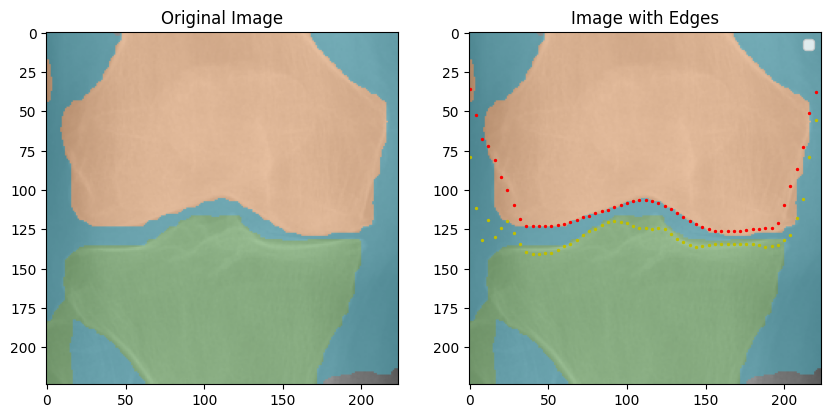

In [2]:
# Plot function for a single image
def plot_dots_on_image(img_path, channels, intvl, step, gap, iterations=1000, initial_temp=1.0, cooling_rate=0.99):
    """
    Plot the detected edges on a single image for demonstration.
    
    Parameters:
    img_path (str): Path to the input image.
    channels (int): Number of image channels (1 for grayscale, 3 for RGB).
    intvl (int): Interval for sampling columns along the image width.
    step (int): Step size for checking pixel intensity changes.
    gap (int): Intensity gap threshold for detecting edges.
    iterations (int): Number of iterations for simulated annealing.
    initial_temp (float): Initial temperature for simulated annealing.
    cooling_rate (float): Cooling rate for simulated annealing.
    """
    original_img = Image.open(img_path)
    np_img = np.array(original_img)
    interval = intvl

    if channels == 1:
        raise NotImplementedError("Simulated annealing is currently implemented for RGB images only.")
    else:
        col_indices = np.arange(0, np_img.shape[1], interval)
        upper_edge_row_vals, lower_edge_row_vals, upper_edge_found, lower_edge_found = find_initial_edges_rgb(np_img, interval, step, gap)
        up_start, low_start = int(np_img.shape[0] / 4), int(np_img.shape[0] * 3 / 4)

        initial_upper_edge_row_vals = upper_edge_row_vals.copy()
        initial_lower_edge_row_vals = lower_edge_row_vals.copy()

        upper_edge_row_vals, lower_edge_row_vals = simulated_annealing(
            col_indices, upper_edge_row_vals, lower_edge_row_vals, up_start, low_start, upper_edge_found, lower_edge_found, iterations, initial_temp, cooling_rate, step
        )
        
        upper_edge_row_vals[upper_edge_found] = initial_upper_edge_row_vals[upper_edge_found]
        lower_edge_row_vals[lower_edge_found] = initial_lower_edge_row_vals[lower_edge_found]

    # Apply local smoothing to refine the edges further
    upper_edge_row_vals = local_smoothing(upper_edge_row_vals, window_size=5)
    lower_edge_row_vals = local_smoothing(lower_edge_row_vals, window_size=5)
    
    # Plotting the image with edges
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[1].imshow(np_img)
    
    axs[1].scatter(range(0, np_img.shape[1], interval), upper_edge_row_vals, color='r', s=2)
    axs[1].scatter(range(0, np_img.shape[1], interval), lower_edge_row_vals, color='y', s=2)
    
    axs[1].set_title('Image with Edges')
    axs[1].legend()
    plt.show()
    
# Example of plotting the results for a single image
img_path = '/kaggle/input/fast-segmented-knee-xray-dataset/fastsam_knee_xray_dataset/train/3/s_9002817R.png'
plot_dots_on_image(img_path, 3, 4, 4, 20)
